# Computer Vision and Deep Learning - Laboratory 4
 
The main objective of this laboratory is to familiarize you with the training process of a neural network. More specifically, you'll follow this ["recipe"](!http://karpathy.github.io/2019/04/25/recipe/) for training  neural networks proposed by Andrew Karpathy.
You'll go through all the steps of training, data preparation, debugging, hyper-parameter tuning.
 
In the second part of the laboratory, you'll experiment with _transfer learning_ and _fine-tuning_.  Transfer learning is a concept from machine learning which allows you to reuse the knowledge gained while solving a problem (in our case the CNN weights) and applying it to solve a similar problem. This is useful when you are facing a classification problem with a small training dataset.


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import threading
import cv2.cv2 as cv2
from tensorflow import keras
from keras import datasets, layers, models
import random
import os
import cv2
import glob
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.7.0
Eager execution: True


# Data loading. Training a neural network. Tuning hyper-parameters. 

Your task for the first part of the laboratory is to train a convolutional nerual network for image classification. You can choose any dataset for image classification. By default you can use the [Oxford Pets dataset](!https://www.robots.ox.ac.uk/~vgg/data/pets/), but you can choose a dataset that you will be using for your project or an interesting dataset from [Kaggle](!https://www.kaggle.com/datasets?search=image).

So the first step would be download your training data.

In [3]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2022-01-06 16:53:44--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M   107MB/s    in 7.1s    

2022-01-06 16:53:51 (106 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2022-01-06 16:53:51--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  88.8MB/s    in 0.2s    

2022-01-06 16:53:51 (88.8 MB

In [4]:
!ls images/*.jpg | head -4
!ls annotations/trimaps/*.png | head -4

images/Abyssinian_100.jpg
images/Abyssinian_101.jpg
images/Abyssinian_102.jpg
images/Abyssinian_103.jpg
annotations/trimaps/Abyssinian_100.png
annotations/trimaps/Abyssinian_101.png
annotations/trimaps/Abyssinian_102.png
annotations/trimaps/Abyssinian_103.png


In [27]:
def make_image_square(img, padding_mode='edge', padding_value=0):
    height, width = img.shape[0], img.shape[1]
    if height > width:
        padding = ((0, 0), ((height - width) // 2, (height - width) // 2), (0, 0))
    else:
        padding = (((width - height) // 2, (width - height) // 2), (0, 0), (0, 0))

    if padding_mode == 'edge':
        return np.pad(img, padding, mode=padding_mode)
    return np.pad(img, padding, mode=padding_mode, constant_values=padding_value)


def get_splits(root_dir):
    image_paths = glob.glob(root_dir + "/*.jpg")
    labels = ["_".join(os.path.basename(path).split("_")[:-1]) for path in image_paths]
    class_names = sorted(list(set(labels)))
    assert (len(class_names) == 37)

    X = image_paths
    y = np.array([class_names.index(label) for label in labels])

    X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=len(class_names)*20,
                                                        random_state=13,
                                                        shuffle=True)

    return X_train, X_test, y_train, y_test


def save_splits(images_paths, anno_dir, out_dir, img_shape = (128, 128)):
    for img_path in images_paths:
        filename = os.path.basename(img_path)
        anno_path = os.path.join(anno_dir, filename.replace('.jpg', '.png'))
        img = cv2.imread(img_path)
        if img is None:
            print('Error while loading image: ', img_path)
            continue
        mask = cv2.imread(anno_path)

        img = make_image_square(img, 'edge')
        mask = make_image_square(mask, 'constant', 2) # 2 - color of the background pixels
        img = cv2.resize(img, img_shape)
        mask = cv2.resize(mask, img_shape, interpolation=cv2.INTER_NEAREST)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        np.save(os.path.join(out_dir, filename.replace('.jpg', '.img.npy')), img)
        np.save(os.path.join(out_dir, filename.replace('.jpg', '.mask.npy')), mask)


def save_db(images_dir, anno_dir, outdir, img_shape = (128, 128)):
    X_train, _, X_test, _ = get_splits(images_dir)
    train_dir = os.path.join(outdir, 'train')
    test_dir = os.path.join(outdir, 'test')
    if os.path.exists(outdir):
        shutil.rmtree(outdir)
    os.mkdir(outdir)
    os.mkdir(train_dir)
    os.mkdir(test_dir)

    save_splits(X_train, anno_dir, train_dir)
    save_splits(X_test, anno_dir, test_dir)


def show_pair(img, mask):
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask')

    plt.show()

def get_labels():
  image_paths = glob.glob('./images' + "/*.jpg")
  labels = ["_".join(os.path.basename(path).split("_")[:-1]) for path in image_paths]
  return labels

save_db('./images', './annotations/trimaps', 'oxford_pets_seg')

Error while loading image:  ./images/Egyptian_Mau_191.jpg
Error while loading image:  ./images/Egyptian_Mau_177.jpg
Error while loading image:  ./images/Egyptian_Mau_145.jpg
Error while loading image:  ./images/Egyptian_Mau_167.jpg
Error while loading image:  ./images/Abyssinian_34.jpg
Error while loading image:  ./images/Egyptian_Mau_139.jpg


## Data loading 
 
Up until now, we could load the data to train our model in a single line of code: we just used numpy.load to read the entire training and test sets into memory.
However, in some cases we won't be able to fit all the data into the memory due to hardware constraints.
 
To alleviate this problem, we'll use the [_Sequence_](!https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence) class from tensorflow which allows us to feed data to our models.
To write a custom data generator, you'll have to 
- write a class that inherits from the class _Sequence_
- override the \_\_len\_\_ method: this method should return the number of batches in a sequence. In this method you can just return the value:
\begin{equation}
len = \frac{training\_samples}{batch\_size}
\end{equation}
- override the \_\_get_item\_\_(self, index) method: this should return a complete batch;
- optionally, you can override other methods, such as on_epoch_end(). For example, here you could shuffle the data after each epoch.
 
What's nice about this is that when calling the fit() method on a model with a _Sequence_, you can set the use_multiprocessing to True and use several workers that will generate the training batches in parallel.
 
``
fit(
    x=None, y=None, batch_size=None, epochs=1, verbose='auto',
    callbacks=None, validation_split=0.0, validation_data=None, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
``
 
Start by writing a custom data generator for the dataset that you chose.



In [31]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, db_dir, batch_size,
                 shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_paths, self.mask_paths = None, None
        self.get_data(db_dir)
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def get_data(self, root_dir):
        """"
        Loads the paths to the images and their corresponding labels from the database directory
        """
        self.image_paths = np.asarray(glob.glob(root_dir + "/*.img.npy"))
        self.mask_paths = np.asarray([path.replace('.img.npy', '.mask.npy') for path in self.image_paths])


    def __len__(self):
        """
        Returns the number of batches per epoch: the total size of the dataset divided by the batch size
        """
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """"
        Generates a batch of data
        """
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]

        batch_x = np.asarray([np.load(img_path).astype(np.float32)/255.0 for img_path in self.image_paths[batch_indices]])
        batch_y = np.asarray([np.expand_dims(np.load(mask_path) - 1, axis=-1) for mask_path in self.mask_paths[batch_indices]])

        return batch_x, batch_y

    def on_epoch_end(self):
        """"
        Called at the end of each epoch
        """
        # if required, shuffle your data after each epoch
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            # you might find np.random.shuffle useful here
            np.random.shuffle(self.indices)

       

Now let's look at some images and samples from our data generator.

32


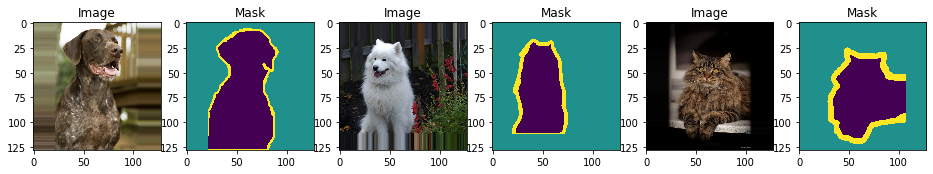

In [33]:
train_generator = DataGenerator("./oxford_pets_seg/train", 32)

batch_x, batch_y = train_generator[0]
print(len(batch_x))
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)//2):
    axes[2*i].set_title('Image')
    axes[2*i].imshow(batch_x[i])

    axes[2*i + 1].set_title('Mask')
    axes[2*i + 1].imshow(batch_y[i][:,:,0]*64)
plt.show()

# CNN architecture

Write a simple tensorflow architecture for a convolutional neural network.
Use the [functional](!https://www.tensorflow.org/guide/keras/functional) api when writing the model.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

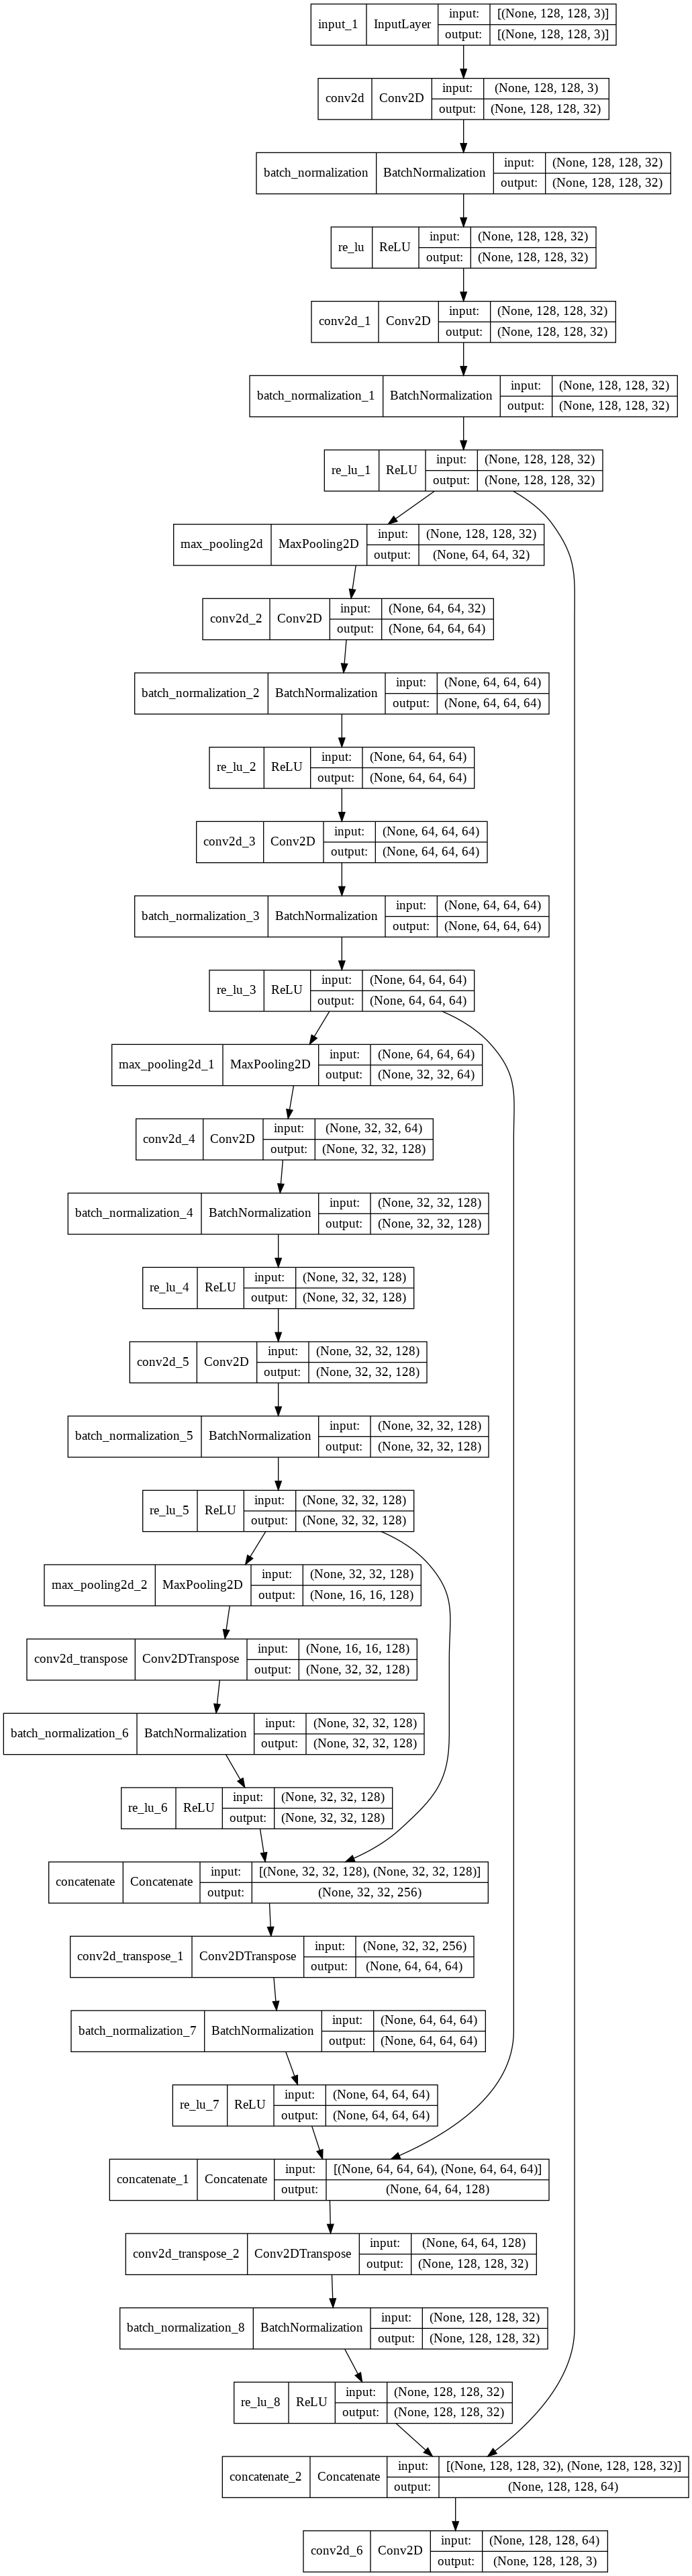

In [19]:
def upsample_block(x, filters, size, stride = 2):
  """
  x - the input of the upsample block
  filters - the number of filters to be applied
  size - the size of the filters
  """
  # TODO your code here
  # transposed convolution
  # BN
  # relu activation
  conv_t_1 = tf.keras.layers.Conv2DTranspose(filters, size, stride, padding='same')(x)
  bn = tf.keras.layers.BatchNormalization()(conv_t_1)
  relu = tf.keras.layers.ReLU()(bn)
  return relu

def build_unet(input_shape, num_classes):
  # muta executia pe gpu
  input_1 = tf.keras.layers.Input(input_shape)

  skips = []

  x = input_1

  for filter in [32, 64, 128]:
    conv_1_1 = tf.keras.layers.Conv2D(filter, 3, padding='same')(x)
    bn_1 = tf.keras.layers.BatchNormalization()(conv_1_1)
    relu_1 = tf.keras.layers.ReLU()(bn_1)  
    conv_1_2 = tf.keras.layers.Conv2D(filter, 3, padding="same")(relu_1)
    bn_2 = tf.keras.layers.BatchNormalization()(conv_1_2)
    relu_2 = tf.keras.layers.ReLU()(bn_2)
    skips.append(relu_2)
    pool_1 = tf.keras.layers.MaxPool2D()(relu_2)
    x = pool_1 
  
  for filter, skip in zip([128, 64, 32], reversed(skips)):
    x = upsample_block(x, filter, 3)
    x = tf.keras.layers.Concatenate()([skip, x])
  
  out = tf.keras.layers.Conv2D(num_classes, 1)(x)

  model = tf.keras.models.Model(input_1, out)
  return model

model = build_unet((128, 128, 3), 3)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

## Training and fine-tuning

Start by reading this blog [post](!http://karpathy.github.io/2019/04/25/recipe/), such that you can get an idea of the pipeline that you'll have to follow when training a model.

- Triple check that your data loading is correct. (Analyse your data.)
- Check that the setup is correct.
- Overfit a simple network.
- Add regularizations.
  - data augmentation
  - weight decay

Finetune the learning rate. Use learning rate decay; here in the [documentation](!https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule) you have an example on how you can use a learning rate scheduler in tensorflow.

You should have at least 7 different trainings. Plot all the training history.

__Save all your models and their training history!__ 


Create a google spreadsheet or a markdown table in this notebook, and report the configuration and the accuracy for all these trains. 

### Other useful videos (bias and variance, basic recipe for training a deep NN)
- https://www.youtube.com/watch?v=NUmbgp1h64E 
- https://www.youtube.com/watch?v=SjQyLhQIXSM&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=2 
- https://www.youtube.com/watch?v=C1N_PDHuJ6Q&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=3 




In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

train_images = DataGenerator("./oxford_pets_seg/train", 32)
test_images = DataGenerator("./oxford_pets_seg/test", 32)

history = model.fit(train_images, epochs=10, 
                    validation_data=test_images)

Epoch 1/10
207/207 [==============================] - 55s 211ms/step - loss: 0.5746 - accuracy: 0.2329 - val_loss: 0.9131 - val_accuracy: 0.0200
Epoch 2/10
207/207 [==============================] - 43s 210ms/step - loss: 0.3866 - accuracy: 0.2324 - val_loss: 0.5292 - val_accuracy: 0.1686
Epoch 3/10
207/207 [==============================] - 43s 209ms/step - loss: 0.3393 - accuracy: 0.2317 - val_loss: 0.3991 - val_accuracy: 0.1917
Epoch 4/10
207/207 [==============================] - 43s 210ms/step - loss: 0.3152 - accuracy: 0.2316 - val_loss: 0.3873 - val_accuracy: 0.1672
Epoch 5/10
207/207 [==============================] - 44s 210ms/step - loss: 0.2995 - accuracy: 0.2313 - val_loss: 0.3317 - val_accuracy: 0.2227
Epoch 6/10
207/207 [==============================] - 43s 209ms/step - loss: 0.2887 - accuracy: 0.2313 - val_loss: 0.3293 - val_accuracy: 0.2657
Epoch 7/10
207/207 [==============================] - 43s 209ms/step - loss: 0.2735 - accuracy: 0.2306 - val_loss: 0.4014 - val_ac

In [42]:

model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=["accuracy"],
    )

train_images = DataGenerator("./oxford_pets_seg/train", 32)
test_images = DataGenerator("./oxford_pets_seg/test", 32)

history = model.fit(train_images, epochs=10, 
                    validation_data=test_images)

Epoch 1/10
207/207 [==============================] - 45s 210ms/step - loss: 0.2545 - accuracy: 0.2296 - val_loss: 0.3061 - val_accuracy: 0.2686
Epoch 2/10
207/207 [==============================] - 43s 209ms/step - loss: 0.2445 - accuracy: 0.2289 - val_loss: 0.2550 - val_accuracy: 0.2194
Epoch 3/10
207/207 [==============================] - 43s 209ms/step - loss: 0.2372 - accuracy: 0.2290 - val_loss: 0.4517 - val_accuracy: 0.1361
Epoch 4/10
207/207 [==============================] - 43s 210ms/step - loss: 0.2326 - accuracy: 0.2287 - val_loss: 0.2531 - val_accuracy: 0.2335
Epoch 5/10
207/207 [==============================] - 43s 209ms/step - loss: 0.2285 - accuracy: 0.2289 - val_loss: 0.2794 - val_accuracy: 0.2240
Epoch 6/10
207/207 [==============================] - 44s 210ms/step - loss: 0.2252 - accuracy: 0.2284 - val_loss: 0.2555 - val_accuracy: 0.2226
Epoch 7/10
207/207 [==============================] - 44s 211ms/step - loss: 0.2197 - accuracy: 0.2286 - val_loss: 0.2556 - val_ac

In [46]:

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=1e-3,
                decay_steps=5,
                decay_rate=0.96)

model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        metrics=["accuracy"],
    )

train_images = DataGenerator("./oxford_pets_seg/train", 32)
test_images = DataGenerator("./oxford_pets_seg/test", 32)

history = model.fit(train_images, epochs=10, 
                    validation_data=test_images)

Epoch 1/10
207/207 [==============================] - 45s 211ms/step - loss: 0.1918 - accuracy: 0.2274 - val_loss: 0.2303 - val_accuracy: 0.2203
Epoch 2/10
207/207 [==============================] - 43s 209ms/step - loss: 0.1751 - accuracy: 0.2271 - val_loss: 0.2296 - val_accuracy: 0.2198
Epoch 3/10
207/207 [==============================] - 43s 210ms/step - loss: 0.1726 - accuracy: 0.2278 - val_loss: 0.2281 - val_accuracy: 0.2214
Epoch 4/10
207/207 [==============================] - 43s 209ms/step - loss: 0.1714 - accuracy: 0.2269 - val_loss: 0.2287 - val_accuracy: 0.2220
Epoch 5/10
207/207 [==============================] - 43s 209ms/step - loss: 0.1714 - accuracy: 0.2270 - val_loss: 0.2289 - val_accuracy: 0.2228
Epoch 6/10
207/207 [==============================] - 43s 209ms/step - loss: 0.1702 - accuracy: 0.2273 - val_loss: 0.2291 - val_accuracy: 0.2215
Epoch 7/10
207/207 [==============================] - 43s 209ms/step - loss: 0.1700 - accuracy: 0.2270 - val_loss: 0.2278 - val_ac

### **Extra credit**

Implement the learning rate scheduler described in the [paper](!https://arxiv.org/pdf/1608.03983.pdf) "SGDR: Stochastic gradient descent with warm restarts". You are mostly interested in Section 3 from the paper.

In [ ]:
# TODO optional extra credit assignment

## Ensembles
 
Pick your N (3 or 5) of the networks that you've trained and create an ensemble. The prediction of the ensemble is just the average of the predictions of the N networks.
 
Evaluate the ensemble (your accuracy should boost by at least 1.5%).


# Transfer learning and fine-tuning
 
In the _tensorflow.keras.applications_ module you can find implementations of several well known CNN architectures (most of the models that we covered during the lecture), as well as the pretrained weights of these models on the ImageNet dataset. 
You can use this module to apply transfer learning and fine-tuning for your classification problem. [Here](!https://keras.io/api/applications/) you can find a comprehensive table with the size of the models, number of parameters, top-1 and top-5 accuracy on the ImageNet dataset.
 
When using deep neural networks, transfer learning is the norm, not the exception.  Transfer learning refers to the situation where what has been learned in one setting is used to improve generalization in another setting.
The transfer learning pipeline can be summarized as follows:
- get the weights of a model trained on similar classification problem (for which more training data is available);
- remove the final classification layer;
- freeze the weights (don't update them during the training process); these layers would be used as a feature extractor;
- add a/some trainable layers over the frozen layers. They will learn how the extracted features can be used to distinguish between the classes of your classification problem.
- train these new layers on your dataset.
 
Next, you can also use fine-tuning. During fine-tuning you will unfreeze the model (or a larger part of the model), and train it on the new data with a very low learning rate.
 
Follow this [tutorial](!https://keras.io/guides/transfer_learning/) to solve this exercise.
 
When following the tutorial
- pay attention to the discussion about the BatchNormalization layers;
- you can skip the section "Transfer learning & fine-tuning with a custom training loop", we'll cover this in the next laboratory;
- pay attention to the loss that you will be using when training your model. In the tutorial the loss is the binary cross entropy loss which is suitable for binary classification problems. If your problem is multi-class you should use the categorical cross entropy loss.
- use the pre-processing required by the network architecture that you chose.
 
To sum up, pick a neural network architecture from the _tensorflow.keras.applications_ module and use transfer learning and fine tuning to train it to classify the images from your dataset (you should use the custom DataGenerator that you wrote for this). 
 Briefly describe the key features of the neural network architecture that you chose and why you chose it.
 
Apply transfer learning (with at least one config for the hyperparameters) and report the performance. Apply fine-tuning  (with at least one config for the hyperparameters) and report the performance.
Finally, plot the performance of the model when you used only transfer learning and the performance of the model when you also used fine-tuning on the same plot.
 
I chose the architecture <font color='red'> TODO </font> , because <font color='red'> TODO </font> .
The key features of this architecture are
- <font color='red'> TODO  </font> 
- <font color='red'> TODO  </font> 
- <font color='red'> TODO  </font> 
 
How does the performance of this fine-tuned model compare to the performance of the network that you trained from scratch?
 




In [ ]:
# TODO your transfer-learning and fine-tuning step